In [1]:
# Add the parent directory to the path
import sys, os
sys.path.insert(0, os.path.abspath("../.."))

## Creating a network model

In [2]:
# Import numpy and ShortestPathGrb class
from numpy import arange, random
from src.models.ShortestPathGrb import shortestPathGrb
from src.models.ShortestPathGrid import ShortestPathGrid

In [3]:
# Set hyperparameters for grid generation
m, n = 5, 5  # grid dimensions
numpy_seed = 42  # for reproducibility
pyepo_seed = 135 # for reproducibility

# Set hyperparameters for data generation
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width

In [4]:
# Set parameters
m, n = (5, 5)
random.seed(42)  # for reproducibility

# Create grid instance
grid = ShortestPathGrid(m, n)

# Create a opt_model instance
opt_model = shortestPathGrb(grid)

Restricted license - for non-production use only - expires 2026-11-23


We generate the random cost vector using PyEPO's generator.

In [5]:
import pyepo

# Set parameters for data generation
num_train_data = 10 # number of training data
num_test_data = 0 # number of test data

# Generate data for shortest path problem
feats, costs = pyepo.data.shortestpath.genData(
    num_train_data+num_test_data, 
    num_feat, 
    (m,n), 
    deg=deg, 
    noise_width=e, 
    seed=pyepo_seed
)

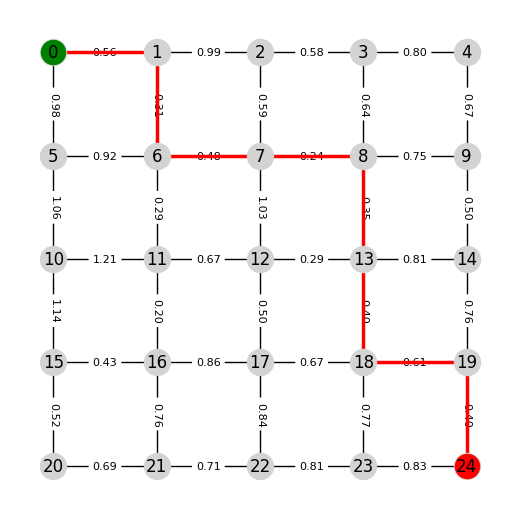

In [6]:
# Choose a cost vector
cost_index = 1
grid_costs = costs[cost_index]
grid_feats = feats[cost_index]

# Set the cost for the grid (Optionally specify the source and target nodes)
opt_model.setObj(grid_costs)

# Solve shortest path problem
path, obj = opt_model.solve(versatile=True)

## Create attacker data set

In [7]:
import pyepo

# Set parameters for data generation
num_train_data = 1000 # number of training data
num_test_data = 100 # number of test data

# Generate data for shortest path problem
feats, costs = pyepo.data.shortestpath.genData(
    num_train_data+num_test_data, 
    num_feat, 
    (m,n), 
    deg=deg, 
    noise_width=e, 
    seed=135
)

In [8]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(
    feats, 
    costs, 
    test_size=num_test_data, 
    random_state=42
)

In [9]:
# Create opt_model for attacker
attacker_opt_model = shortestPathGrb(ShortestPathGrid(m, n))

# Create datasets for training and testing
dataset_train = pyepo.data.dataset.optDataset(attacker_opt_model, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(attacker_opt_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3249.83it/s]

Optimizing for optDataset...



100%|██████████| 100/100 [00:00<00:00, 3339.12it/s]


In [10]:
# Wrap dataset into PyTorch DataLoader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Train attacker

In [11]:
from src.models.LinearRegression import LinearRegression

# Instantiate linear regression model for prediction
pred_model = LinearRegression(num_feat=num_feat, num_edges=attacker_opt_model.num_cost)

In [12]:
# Init SPO+ loss
spop = pyepo.func.SPOPlus(attacker_opt_model, processes=1)

# Init optimizer
from torch import optim
optimizer = optim.Adam(pred_model.parameters(), lr=1e-2)

Num of cores: 1


In [13]:
from src.models.trainer import Trainer

# Set the number of epochs for training
epochs = 5

# Create a trainer instance
trainer = Trainer(pred_model=pred_model, 
                  opt_model=attacker_opt_model, 
                  optimizer=optimizer, 
                  loss_fn=spop
                )

train_loss_log, train_regret_log, test_loss_log, test_regret_log = trainer.fit(loader_train, loader_test, epochs=epochs)

Epoch 00 | Train Loss: 4.1093 | Train Regret: 0.0880 | Test Loss: 1.6337 | Test Regret: 0.0818
Epoch 01 | Train Loss: 1.5733 | Train Regret: 0.0764 | Test Loss: 1.1458 | Test Regret: 0.0639
Epoch 02 | Train Loss: 1.3664 | Train Regret: 0.0737 | Test Loss: 1.0420 | Test Regret: 0.0739
Epoch 03 | Train Loss: 1.3203 | Train Regret: 0.0736 | Test Loss: 1.0408 | Test Regret: 0.0775
Epoch 04 | Train Loss: 1.3311 | Train Regret: 0.0737 | Test Loss: 1.0386 | Test Regret: 0.0730


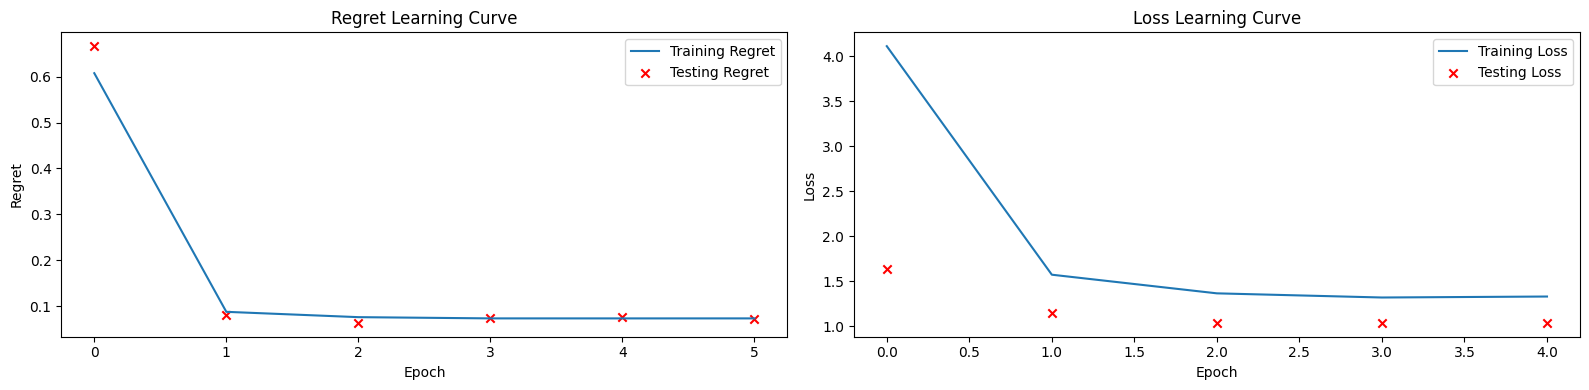

Final regret on test set:  0.07303375223010432


In [14]:
Trainer.vis_learning_curve(
    trainer,
    train_loss_log,
    train_regret_log,
    test_loss_log,
    test_regret_log
)

print("Final regret on test set: ", test_regret_log[-1])

## Estimate edge costs form features

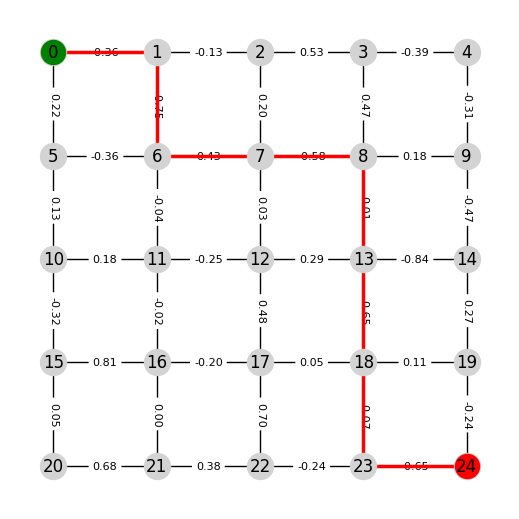

In [ ]:
import torch

# Predict costs using the trained model
costs_pred = pred_model(torch.FloatTensor(grid_feats))

# Create a new opt_model instance with the predicted costs
attacker_opt_model.setObj(costs_pred.detach().numpy())

# Solve the attacker's shortest path problem
attacker_path, attacker_obj = attacker_opt_model.solve(versatile=True)

In [ ]:
# Compare true cost of attacker's shortest path with true cost and true shortest path
print("True cost of attacker's shortest path: ", opt_model.evaluate(attacker_path))
print("True cost of optimal path: ", obj)
# TODO: Print regret?

True cost of attacker's shortest path:  3.9427704011405327
True cost of optimal path:  3.3549304753541946


## Interdictor

In [17]:
# Define the interdiction cost
interdiction_cost = random.rand(grid.num_cost)

# Define Budget
k = 5

# Print the interdiction cost
interdiction_cost

array([0.34106635, 0.11347352, 0.92469362, 0.87733935, 0.25794163,
       0.65998405, 0.8172222 , 0.55520081, 0.52965058, 0.24185229,
       0.09310277, 0.89721576, 0.90041806, 0.63310146, 0.33902979,
       0.34920957, 0.72595568, 0.89711026, 0.88708642, 0.77987555,
       0.64203165, 0.08413996, 0.16162871, 0.89855419, 0.60642906,
       0.00919705, 0.10147154, 0.66350177, 0.00506158, 0.16080805,
       0.54873379, 0.6918952 , 0.65196126, 0.22426931, 0.71217922,
       0.23724909, 0.3253997 , 0.74649141, 0.6496329 , 0.84922341])

In [18]:
from src.solvers.BendersDecomposition import BendersDecomposition

# Initialize the BendersDecomposition with the opt_model
benders = BendersDecomposition(opt_model, k, interdiction_cost, max_cnt=20, eps=1e-3)

In [19]:
interdictions_x, shortest_path_y, z_min = benders.solve()

Bender's decomposition running:
-------------------------------
Iteration 1: z_max = 6.527886083772425, z_min = 3.3549304753541946
Iteration 2: z_max = 5.801930404902185, z_min = 5.075293332338333
Iteration 3: z_max = 5.630670325819105, z_min = 5.418478459119797
Iteration 4: z_max = 5.5141025314239425, z_min = 5.003964319825172
Iteration 5: z_max = 5.418478428790143, z_min = 5.096749171614647
Iteration 6: z_max = 5.418478428790143, z_min = 5.418478459119797
-------------------------------
Found epsilon-optimal solution after 6 iterations with epsilon = -0.00


Original shortest path cost: 	3.35
New shortest path cost: 	5.42


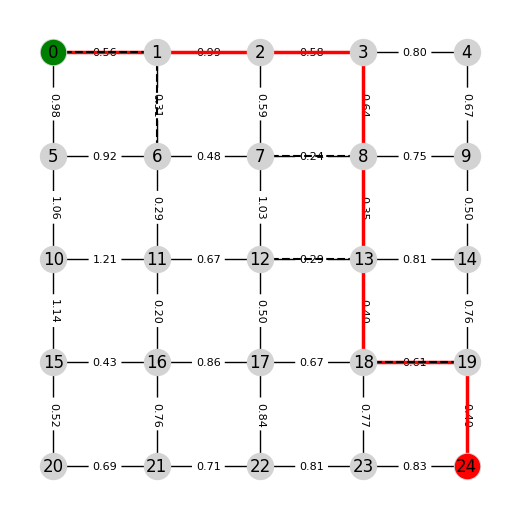

In [20]:
print(f"Original shortest path cost: \t{obj:.2f}\nNew shortest path cost: \t{z_min:.2f}")

grid.visualize(colored_edges=shortest_path_y, dashed_edges=interdictions_x)

In [22]:
# Next: Attacker shortest path if defender knows its model

In [23]:
# Initialize the BendersDecomposition with the attacker_opt_model
benders2 = BendersDecomposition(attacker_opt_model, k, interdiction_cost, max_cnt=20, eps=1e-3)

In [24]:
interdictions_x_2, shortest_path_y_2, z_min_2 = benders2.solve()

Bender's decomposition running:
-------------------------------
Iteration 1: z_max = 1.2447504722991942, z_min = -2.5998076424002647
Iteration 2: z_max = -0.13693559320312954, z_min = -1.257877491414547
Iteration 3: z_max = -0.4780019441056069, z_min = -0.7504514995962381
Iteration 4: z_max = -0.6795620515639726, z_min = -0.7861633710563183
Iteration 5: z_max = -0.679562051563959, z_min = -0.7883566617965698
Iteration 6: z_max = -0.6795620515639581, z_min = -1.079958317859564
Iteration 7: z_max = -0.7102414109267591, z_min = -0.7102414109394886
-------------------------------
Found epsilon-optimal solution after 7 iterations with epsilon = 0.00


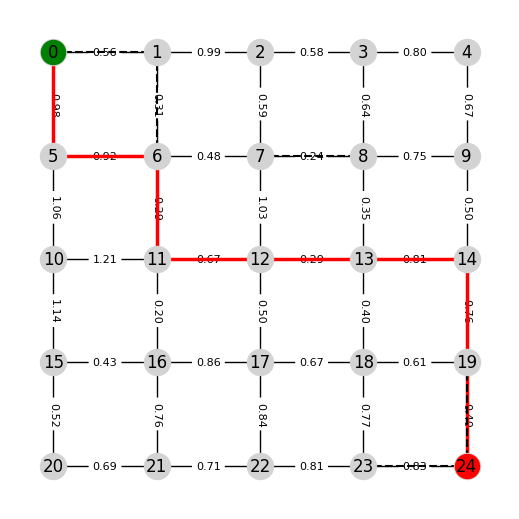

In [43]:
grid.visualize(colored_edges=shortest_path_y_2, dashed_edges=interdictions_x_2)

In [46]:
from tabulate import tabulate

table_with_attacker = [[
        "Game Setup", 
        "True Attacker Path Cost", 
        "Estimated Attacker Path Cost", 
        "True Attacker Path Cost (Interdicted)", 
        "Estimated Attacker Path Cost (Interdicted)"
    ], [
        "B1 + A1", 
        obj, opt_model.evaluate(path), 
        z_min, 
        z_min
    ], [
        "B1 + A2", 
        opt_model.evaluate(attacker_path), 
        attacker_obj, 
        z_min, 
        attacker_opt_model.evaluate(shortest_path_y) + interdictions_x @ interdiction_cost
    ], [
        "B2 + A2", 
        opt_model.evaluate(attacker_path), 
        attacker_obj, 
        opt_model.evaluate(shortest_path_y) + interdictions_x_2 @ interdiction_cost, z_min_2
    ]
]

table = [[
        "Game Setup", 
        "True Attacker Path Cost", 
        "True Attacker Path Cost (Interdicted)"
    ], [
        "B1 + A1", 
        obj, z_min
    ], [
        "B1 + A2", 
        opt_model.evaluate(attacker_path), 
        z_min
    ], [
        "B2 + A2", 
        opt_model.evaluate(attacker_path), 
        opt_model.evaluate(shortest_path_y_2) + (interdictions_x_2 * shortest_path_y_2) @ interdiction_cost
    ]
]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════╤═══════════════════════════╤═════════════════════════════════════════╕
│ Game Setup   │   True Attacker Path Cost │   True Attacker Path Cost (Interdicted) │
╞══════════════╪═══════════════════════════╪═════════════════════════════════════════╡
│ B1 + A1      │                   3.35493 │                                 5.41848 │
├──────────────┼───────────────────────────┼─────────────────────────────────────────┤
│ B1 + A2      │                   3.94277 │                                 5.41848 │
├──────────────┼───────────────────────────┼─────────────────────────────────────────┤
│ B2 + A2      │                   3.94277 │                                 5.36281 │
╘══════════════╧═══════════════════════════╧═════════════════════════════════════════╛
